In [1]:

from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import torch.nn.functional as F
import functools
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import time

import Augmentor

from torchsummary import summary

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
# Training settings
batch_size = 50

In [6]:
#%%

# p = Augmentor.Pipeline()
# p.random_erasing(0.5,0.4)




train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop((32, 32), padding=4),   #left, top, right, bottom
#     p.torch_transform(),
#     p.sample(10000),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/lee/Research/11.project_tangqing/data',
                               train=True,
                               transform=train_transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='/home/lee/Research/11.project_tangqing/data',
                              train=False,
                              transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, # 64
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

dataloaders = {
    'train': train_loader,
    'test' : test_loader    
}
image_datasets = {
    'train': train_dataset,
    'test' : test_dataset
}
dataset_sizes = {
    'train': len(image_datasets['train']),
    'test' : len(image_datasets['test'])
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print('train_size: ',dataset_sizes['train'],'\ntest_size : ',dataset_sizes['test'])
print(classes)
print('len class: ', len(classes))



Files already downloaded and verified
train_size:  50000 
test_size :  10000
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
len class:  10


In [7]:
# Get a batch of training data
inputs1, classes = next(iter(dataloaders['train']))

In [ ]:
images1 = inputs1[49].numpy()
print(images1.shape)
images1 = np.transpose(images1,[1,2,0])
print(images1.shape)
# plt.subplot(121)
plt.imshow(images1)

In [ ]:
# import cv2

# img = np.zeros((512,512,3), np.uint8)
# img = cv2.line(img,(0,0),(511,511),(255,0,0),5)

# cv2.imshow('image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


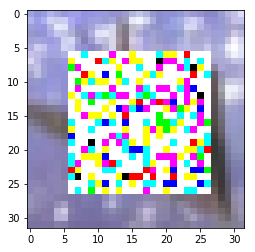

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


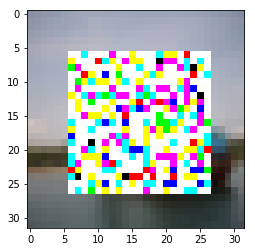

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


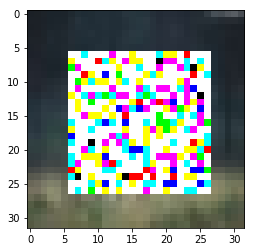

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


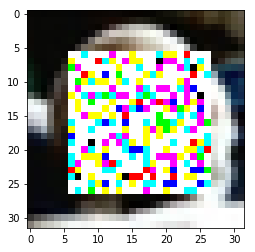

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


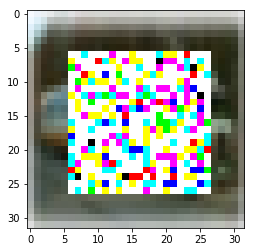

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


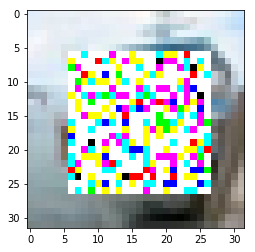

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


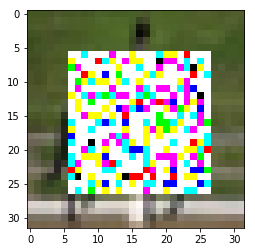

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


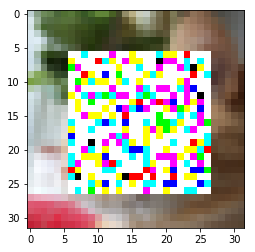

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


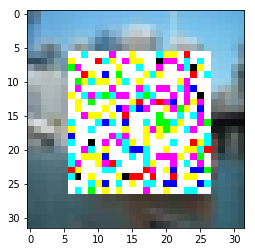

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


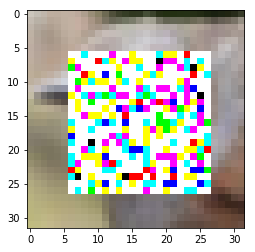

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


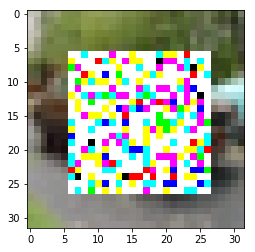

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


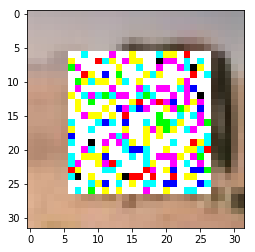

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


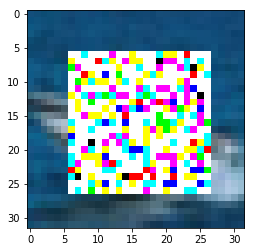

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


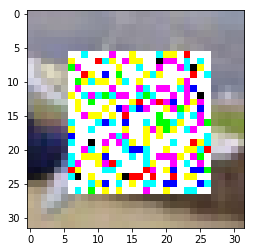

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


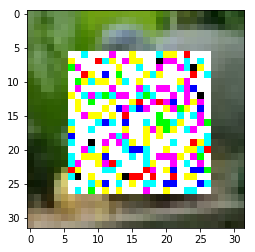

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


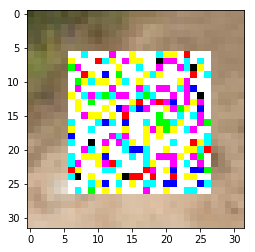

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


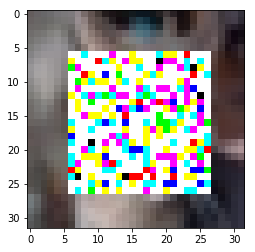

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


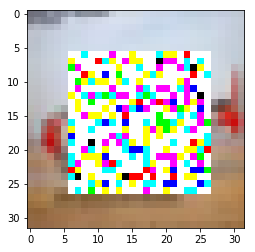

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


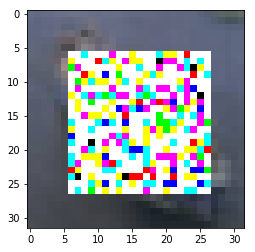

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


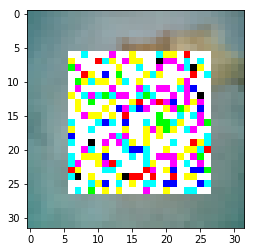

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


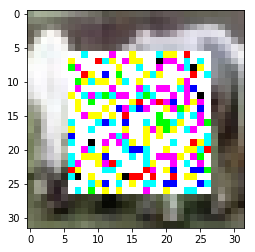

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


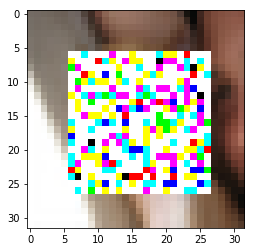

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


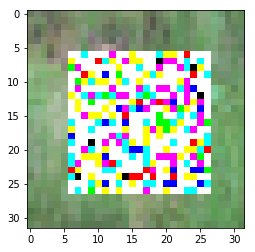

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


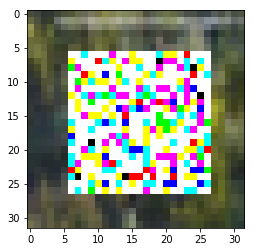

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


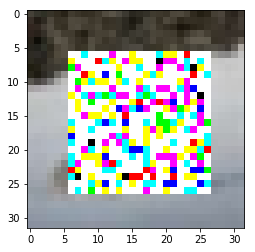

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


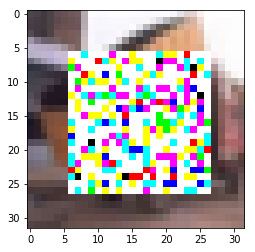

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [9]:
Height = 32
Width = 32
Channels = 3

# # ADDING NOISE
noise = np.random.randint(5, size = (164, 278, 3), dtype = 'uint8')
for n in range(1000):
    inputs, classes = next(iter(dataloaders['train']))
    for m in range(batch_size):
        images_ = inputs[m].numpy()
        images_ = np.transpose(images_, [1,2,0])
        for i in range(Width):
            for j in range(Height):
                for k in range(Channels):
                    if (i < 6 or j < 6 or i > 26 or j > 26):
                        images_[i][j][k] = images_[i][j][k]
                    else:
                        images_[i][j][k] = noise[i][j][k]
        plt.imshow(images_)
        plt.show()
# plt.imshow(img)
# plt.show()